# STAT207 Mini-Project #2 - Video Games Dataset Predictive Model


Lucino Sotelo

In [107]:
#Imports here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import KFold

# Ignore scikit-learn ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## 1. Introduction

Hello,

My name is Lucino Sotelo and below you will find my analysis report based upon the video games data set, it was collected from crowd-sourced data on "How Long to Beat". It has information about the sales and playtime of over a thousand video games released between 2004 and 2010. This csv was downloaded on 3/27/2024. The primary goal of this mini project is to build a predictive model that will effectively predict "Metric Review Scores" for new datasets. The five explanatory variables that I chose to help predict "Metric Review Scores" are: "The average length of the games main storyline","the typical used price that was recorded for buying the game" , "the genre that the game falls under", "The sales that the game generates", and "the average length of the games main storyline + the length of all the extra story lines". Our secondary research goal is that we would like for our chosen model to also yield reliable interpretative insights about the nature of the relationship between the variables in the dataset. The reason that one would want a predictive model that predicts games review scores based on my descriptive variables would be to see if a game would be enjoyables based on things like "sales" or "genre" and from there decide if its a game you want to buy. This could be useful to someone who is a very frequent buyer of video games and has to choose between whether to buy one videogame or another because they don't have time to play every new game.

## 2. Dataset Discussion

This is my dataset as stated before it was accessed of March 27th, 2024. This is the link:https://corgis-edu.github.io/corgis/csv/video_games/ 

In [55]:
df = pd.read_csv("video_games.csv")
df.head()

,Title,Features.Handheld?,Features.Max Players,Features.Multiplatform?,Features.Online?,Metadata.Genres,Metadata.Licensed?,Metadata.Publishers,Metadata.Sequel?,Metrics.Review Score,...,Length.Main + Extras.Average,Length.Main + Extras.Leisure,Length.Main + Extras.Median,Length.Main + Extras.Polled,Length.Main + Extras.Rushed,Length.Main Story.Average,Length.Main Story.Leisure,Length.Main Story.Median,Length.Main Story.Polled,Length.Main Story.Rushed
0,Super Mario 64 DS,True,1,True,True,Action,True,Nintendo,True,85,...,24.916667,29.966667,25.000000,16,18.333333,14.333333,18.316667,14.500000,21,9.700000
1,Lumines: Puzzle Fusion,True,1,True,True,Strategy,True,Ubisoft,True,89,...,9.750000,9.866667,9.750000,2,9.616667,10.333333,11.083333,10.000000,3,9.583333
2,WarioWare Touched!,True,2,True,True,"Action,Racing / Driving,Sports",True,Nintendo,True,81,...,3.850000,5.666667,3.333333,11,2.783333,1.916667,2.933333,1.833333,30,1.433333
3,Hot Shots Golf: Open Tee,True,1,True,True,Sports,True,Sony,True,81,...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000
4,Spider-Man 2,True,1,True,True,Action,True,Activision,True,61,...,12.766667,17.316667,12.500000,12,10.483333,8.350000,11.083333,8.000000,23,5.333333


In [56]:
df.shape[0]

1212

## 3. Dataset Cleaning

Now we are going to clean the data set of the things we don't need like other columns and check for implicit and explicit missing values. If we find any we will just get rid of them and then see how many rows we are left with at the end of our dataset cleaning.

In [74]:
df["LengthMainExtrasAverage"]= df['Length.Main + Extras.Average']
df["Sales"] = df['Metrics.Sales']
df["ReviewScore"] = df['Metrics.Review Score']
df["Avgmainlength"] = df['Length.Main Story.Average']
df["Genres"] = df['Metadata.Genres']
df["Usedprice"] = df['Metrics.Used Price']
df1 = df[['ReviewScore','Usedprice','Sales','LengthMainExtrasAverage','Avgmainlength','Genres']]
df1.head()

,ReviewScore,Usedprice,Sales,LengthMainExtrasAverage,Avgmainlength,Genres
0,85,24.95,4.69,24.916667,14.333333,Action
1,89,14.95,0.56,9.750000,10.333333,Strategy
2,81,22.95,0.54,3.850000,1.916667,"Action,Racing / Driving,Sports"
3,81,12.95,0.49,0.000000,0.000000,Sports
4,61,14.95,0.45,12.766667,8.350000,Action


In full transparency I had to come back and change the name for "Length.Main + Extras.Average" because I was having problems with the + when writing out the full regression model. Then I had to come back again and change all of the names to make it easier on myself going forward.

In [75]:
len(df1)

1212

In [76]:
missing = df1.isna().sum()
missing

ReviewScore                0
Usedprice                  0
Sales                      0
LengthMainExtrasAverage    0
Avgmainlength              0
Genres                     0
dtype: int64

In [70]:
np.unique(df1['LengthMainExtrasAverage'].values)

array([  0.        ,   0.88333333,   0.93333333,   1.        ,
         1.11666667,   2.25      ,   2.4       ,   2.68333333,
         2.83333333,   2.96666667,   3.08333333,   3.1       ,
         3.21666667,   3.26666667,   3.55      ,   3.66666667,
         3.85      ,   4.        ,   4.11666667,   4.13333333,
         4.5       ,   4.51666667,   4.75      ,   4.83333333,
         4.86666667,   5.        ,   5.06666667,   5.08333333,
         5.23333333,   5.26666667,   5.33333333,   5.41666667,
         5.5       ,   5.61666667,   5.66666667,   5.86666667,
         5.93333333,   6.        ,   6.15      ,   6.25      ,
         6.26666667,   6.28333333,   6.33333333,   6.35      ,
         6.4       ,   6.6       ,   6.63333333,   6.75      ,
         6.8       ,   6.9       ,   6.98333333,   7.        ,
         7.16666667,   7.2       ,   7.25      ,   7.33333333,
         7.5       ,   7.56666667,   7.58333333,   7.6       ,
         7.66666667,   7.75      ,   7.85      ,   7.86

In [78]:
df2 = df1[df1['LengthMainExtrasAverage'] > 0]
len(df2)

708

What I did here is just make sure I took out all of the values of this column "the average length of the main story + extras" that were equal to 0 because that just means the data would've been the same as NA it was an implicit missing value that I took out in order to make the data more accurate.

In [79]:
df3 = df2[df2['Avgmainlength'] > 0]
len(df3)

669

In [80]:
len(df1)-len(df3)

543

Dropping the implicit missing values from both the lengths had me drop a considerable 543 rows and leaves me with 669 rows. This might me something we come back to when talking about the results of this project.

## 4. Preliminary Analysis

Now I am going to do a preliminary analysis of the data right now and see if there is anything to look out for. First I will create a visualization be using the scatterplot graph and then we can analyze to see if anything stands out too much in terms of possible issues. Then we will create

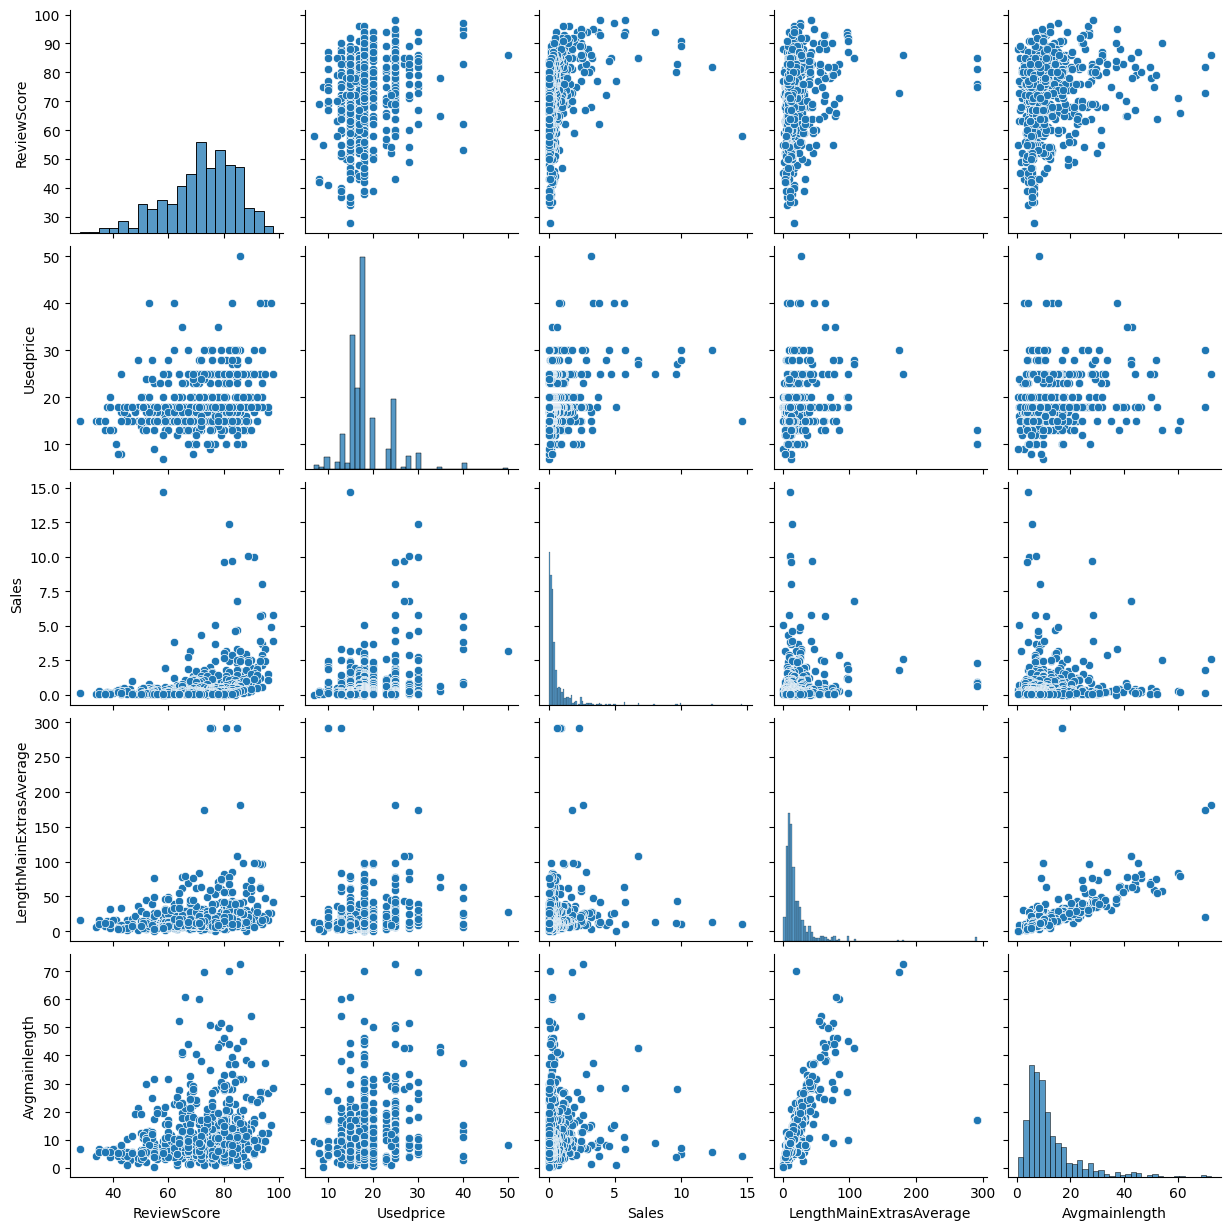

In [81]:
sns.pairplot(df3)
plt.show()

In [86]:
df3

,ReviewScore,Usedprice,Sales,LengthMainExtrasAverage,Avgmainlength,Genres
0,85,24.95,4.69,24.916667,14.333333,Action
1,89,14.95,0.56,9.750000,10.333333,Strategy
2,81,22.95,0.54,3.850000,1.916667,"Action,Racing / Driving,Sports"
4,61,14.95,0.45,12.766667,8.350000,Action
5,67,12.95,0.41,20.833333,15.500000,Simulation
...,...,...,...,...,...,...
1202,56,17.95,0.04,26.266667,19.600000,Strategy
1204,58,11.95,0.03,4.516667,5.183333,Action
1206,67,12.95,0.03,13.200000,9.650000,Role-Playing (RPG)
1207,71,17.95,0.03,11.500000,8.800000,Adventure


In [87]:
lin_mod = smf.ols(formula='ReviewScore~Sales+Usedprice+LengthMainExtrasAverage+Avgmainlength+Genres', data=df3).fit()
lin_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ReviewScore   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     5.452
Date:                Sun, 31 Mar 2024   Prob (F-statistic):           3.06e-20
Time:                        15:21:50   Log-Likelihood:                -2552.7
No. Observations:                 669   AIC:                             5179.
Df Residuals:                     632   BIC:                             5346.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               60.5601      1.904     31.801      0.000      56.821      64.300
Genres[T.Action,Adventure]                              -1.4513      2.609     -0.556      0.578      -6.575       3.672
Genres[T.Action,Adventure,Racing / Driving,Sports]       8.9186      8.030      1.111      0.267      -6.850      24.687
Genres[T.Action,Adventure,Role-Playing (RPG)]           12.9094      8.050      1.604      0.109      -2.899      28.718
Genres[T.Action,Adventure,Strategy]                     10.2936     11.335      0.908      0.364     -11.965      32.552
Genres[T.Action,Racing / Driving]                        3.4698      2.238      1.550      0.122      -0.925       7.865
Genres[T.Action,Racing / Driving,Role-Playing (RPG)]     8.5381      6.557      1.302      0.193      -4.338      21.415
Genres[T.Action,Racing / Driving,Sports]                 7.8257      5.768      1.357      0.175      -3.501      19.152
Genres[T.Action,Role-Playing (RPG)]                      0.2745      2.055      0.134      0.894      -3.761       4.310
Genres[T.Action,Role-Playing (RPG),Strategy]            -4.7577      8.062     -0.590      0.555     -20.590      11.075
Genres[T.Action,Simulation]                             10.7615      2.576      4.177      0.000       5.702      15.821
Genres[T.Action,Simulation,Sports]                       3.8347     11.323      0.339      0.735     -18.401      26.071
Genres[T.Action,Simulation,Strategy]                     2.2073     11.326      0.195      0.846     -20.033      24.448
Genres[T.Action,Sports]                                 -3.0854      3.878     -0.796      0.427     -10.700       4.530
Genres[T.Action,Strategy]                                1.0856      2.590      0.419      0.675      -4.001       6.173
Genres[T.Adventure]                                     -4.2556      3.091     -1.377      0.169     -10.325       1.814
Genres[T.Adventure,Educational,Strategy]                10.2706     11.339      0.906      0.365     -11.996      32.537
Genres[T.Adventure,Role-Playing (RPG)]                  -4.0646      5.880     -0.691      0.490     -15.611       7.482
Genres[T.Adventure,Simulation]                           5.9130      5.730      1.032      0.303      -5.340      17.166
Genres[T.Educational,Sports]                           -13.1897     11.743     -1.123      0.262     -36.249       9.870
Genres[T.Racing / Driving]                              -1.7961      2.171     -0.827      0.408      -6.059       2.467
Genres[T.Racing / Driving,Simulation]                    5.2258     11.345      0.461      0.645     -17.053      27.504
Genres[T.Racing / Driving,Simulation,Sports]            12

<h3>Variable Transformation<h3>

In [93]:
df4 = df3
df4['Sales_ln'] = np.log(df3['Sales'])
df4['Usedprice_ln'] = np.log(df3['Usedprice'])
df4['LengthMainExtrasAverage_ln'] = np.log(df3['LengthMainExtrasAverage'])
df4['Avgmainlength_ln'] = np.log(df3['Avgmainlength'])
df_transform = df4[['ReviewScore','Sales_ln','Usedprice_ln','LengthMainExtrasAverage_ln','Avgmainlength_ln','Genres']]
df_transform.head()


/var/folders/n3/96p53mv12hs5k7wjv89vpj5w0000gn/T/ipykernel_49648/2079230296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Sales_ln'] = np.log(df3['Sales'])
/var/folders/n3/96p53mv12hs5k7wjv89vpj5w0000gn/T/ipykernel_49648/2079230296.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Usedprice_ln'] = np.log(df3['Usedprice'])
/var/folders/n3/96p53mv12hs5k7wjv89vpj5w0000gn/T/ipykernel_49648/2079230296.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,ReviewScore,Sales_ln,Usedprice_ln,LengthMainExtrasAverage_ln,Avgmainlength_ln,Genres
0,85,1.545433,3.216874,3.215537,2.662588,Action
1,89,-0.579818,2.704711,2.277267,2.335375,Strategy
2,81,-0.616186,3.133318,1.348073,0.650588,"Action,Racing / Driving,Sports"
4,61,-0.798508,2.704711,2.546838,2.122262,Action
5,67,-0.891598,2.561096,3.036554,2.740840,Simulation


In [97]:
lin_mod = smf.ols(formula='ReviewScore~Sales_ln+Usedprice_ln+LengthMainExtrasAverage_ln+Avgmainlength_ln+Genres', data=df_transform).fit()
lin_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ReviewScore   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     8.582
Date:                Sun, 31 Mar 2024   Prob (F-statistic):           2.28e-35
Time:                        17:01:25   Log-Likelihood:                -2510.0
No. Observations:                 669   AIC:                             5094.
Df Residuals:                     632   BIC:                             5261.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               50.9989      5.665      9.003      0.000      39.875      62.123
Genres[T.Action,Adventure]                               0.3076      2.458      0.125      0.900      -4.519       5.135
Genres[T.Action,Adventure,Racing / Driving,Sports]      10.6405      7.548      1.410      0.159      -4.182      25.463
Genres[T.Action,Adventure,Role-Playing (RPG)]           12.0254      7.558      1.591      0.112      -2.816      26.867
Genres[T.Action,Adventure,Strategy]                     15.1540     10.659      1.422      0.156      -5.777      36.085
Genres[T.Action,Racing / Driving]                        3.8325      2.108      1.818      0.070      -0.307       7.972
Genres[T.Action,Racing / Driving,Role-Playing (RPG)]     8.8379      6.156      1.436      0.152      -3.251      20.927
Genres[T.Action,Racing / Driving,Sports]                 6.4113      5.391      1.189      0.235      -4.176      16.998
Genres[T.Action,Role-Playing (RPG)]                     -0.2379      1.951     -0.122      0.903      -4.069       3.593
Genres[T.Action,Role-Playing (RPG),Strategy]            -0.8781      7.575     -0.116      0.908     -15.753      13.997
Genres[T.Action,Simulation]                              7.2049      2.497      2.886      0.004       2.302      12.108
Genres[T.Action,Simulation,Sports]                       1.1008     10.630      0.104      0.918     -19.774      21.975
Genres[T.Action,Simulation,Strategy]                     1.1920     10.630      0.112      0.911     -19.682      22.066
Genres[T.Action,Sports]                                 -3.1247      3.612     -0.865      0.387     -10.218       3.969
Genres[T.Action,Strategy]                                1.9488      2.420      0.805      0.421      -2.804       6.702
Genres[T.Adventure]                                     -1.5502      2.919     -0.531      0.596      -7.283       4.183
Genres[T.Adventure,Educational,Strategy]                 5.6582     10.649      0.531      0.595     -15.254      26.571
Genres[T.Adventure,Role-Playing (RPG)]                  -0.0028      5.480     -0.001      1.000     -10.765      10.759
Genres[T.Adventure,Simulation]                           5.5794      5.386      1.036      0.301      -4.997      16.156
Genres[T.Educational,Sports]                            -4.5410     10.724     -0.423      0.672     -25.599      16.517
Genres[T.Racing / Driving]                              -1.7949      2.029     -0.885      0.377      -5.780       2.190
Genres[T.Racing / Driving,Simulation]                   -0.2690     10.662     -0.025      0.980     -21.206      20.668
Genres[T.Racing / Driving,Simulation,Sports]            11

<h3>Interactions<h3>

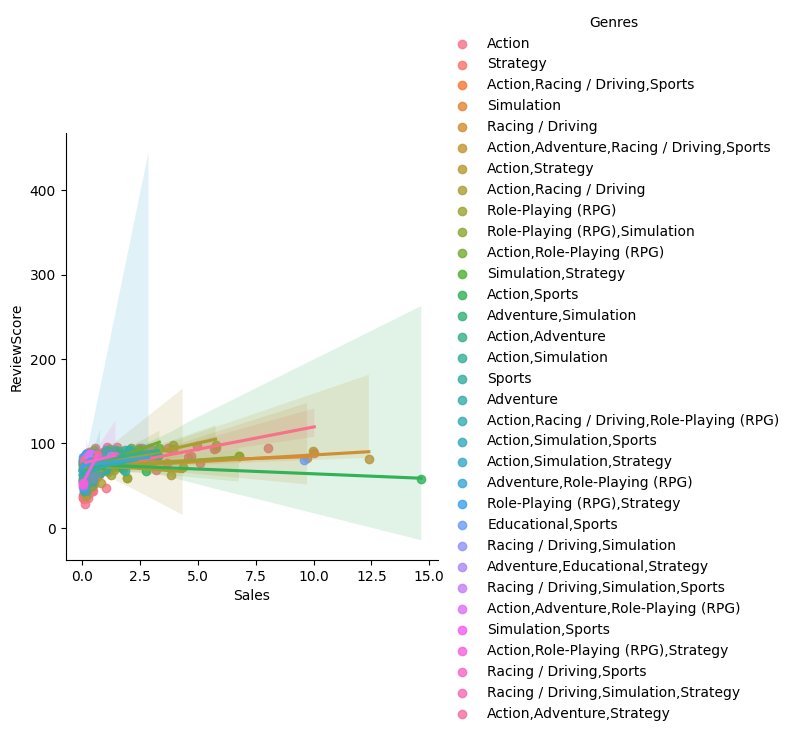

In [99]:
sns.lmplot(x='Sales', y='ReviewScore', hue='Genres', data=df3)
plt.show()

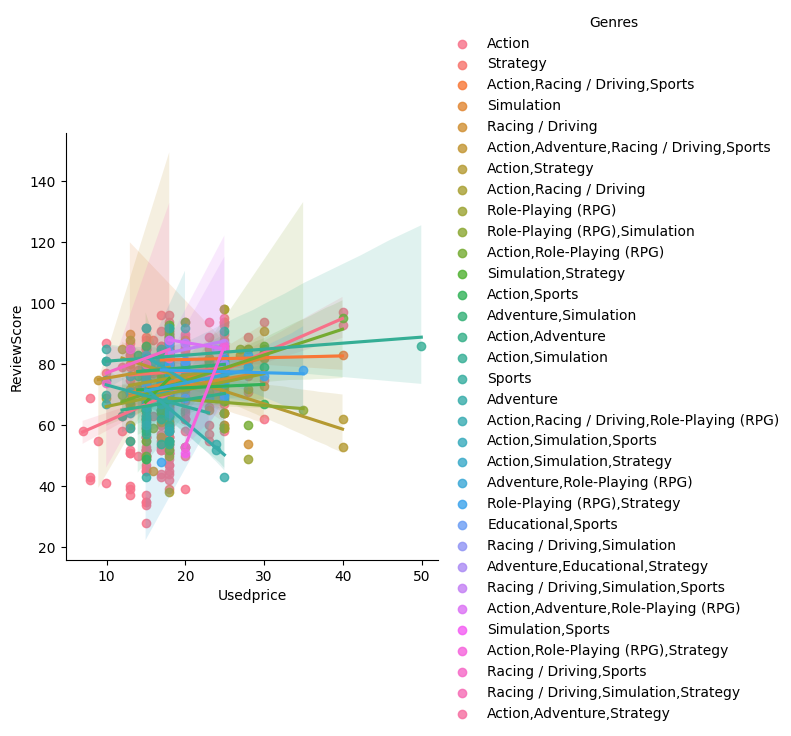

In [100]:
sns.lmplot(x='Usedprice', y='ReviewScore', hue='Genres', data=df3)
plt.show()

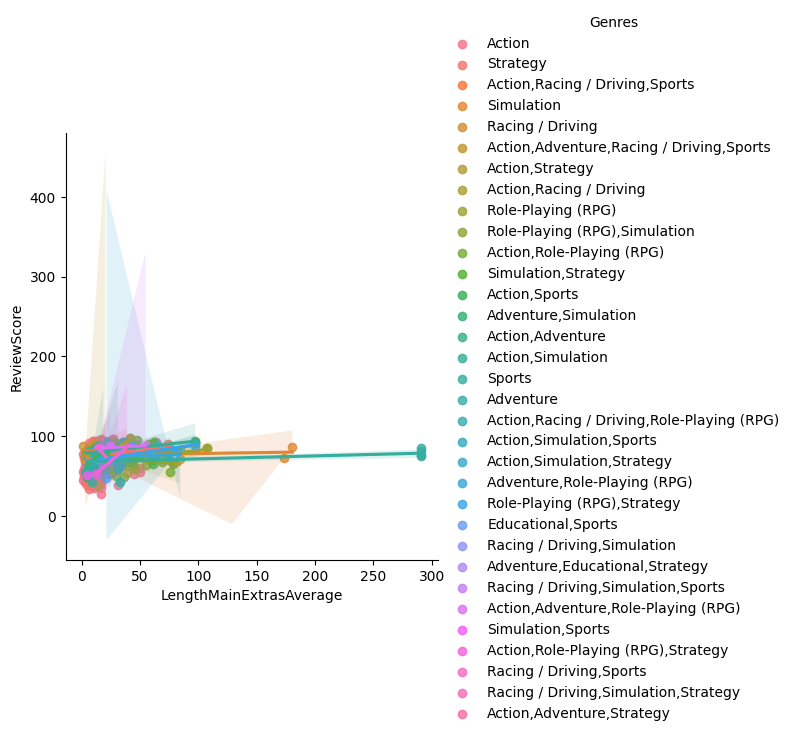

In [101]:
sns.lmplot(x='LengthMainExtrasAverage', y='ReviewScore', hue='Genres', data=df3)
plt.show()

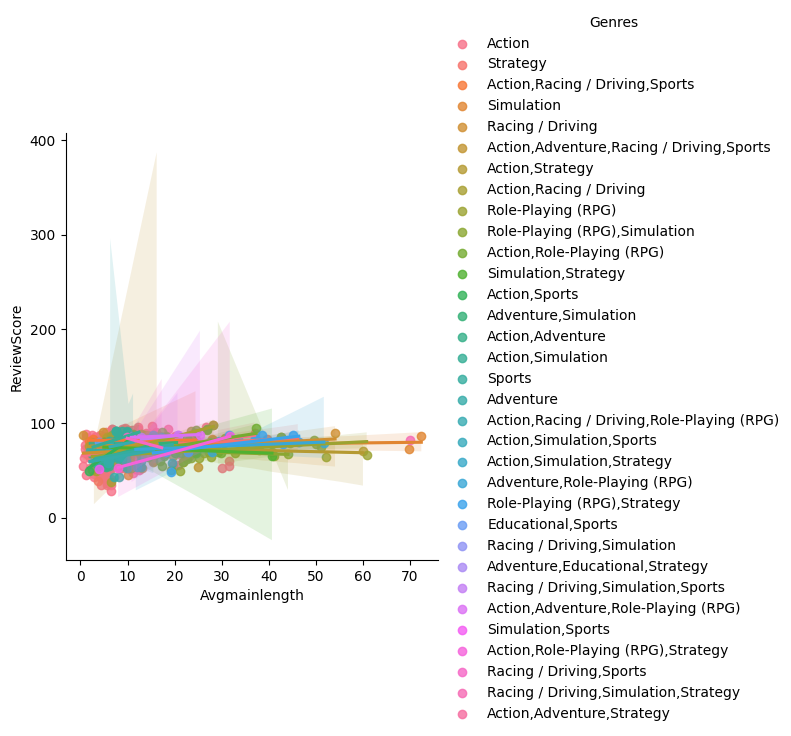

In [102]:
sns.lmplot(x='Avgmainlength', y='ReviewScore', hue='Genres', data=df3)
plt.show()

By looking at the scatter plots above we can see how the variables interact with the Genre variable based on the slopes. For some the slopes are very similar showing a lack of interaction but for the ones with a bunch of different slopes that shows more interaction which can be a good thing.

## 5. Predictive Models

The first thing I have to do is change the Genre variable into a indicator variable so it can be put to a number since it doesn't make sense right now as a non numerical variable. What that also means is that I have to seperate it into each different different Genre and give it a 1/0 value dependign on if it falls under that category. After that I will train-test split the dataset so that there are training and test datasets. Then I will z-score scale those training and test data sets.

In [112]:
df5 = pd.get_dummies(df_transform[['Genres']], drop_first=True, dtype=int).reset_index().drop(['index'], axis=1)
df5

,"Genres_Action,Adventure","Genres_Action,Adventure,Racing / Driving,Sports","Genres_Action,Adventure,Role-Playing (RPG)","Genres_Action,Adventure,Strategy","Genres_Action,Racing / Driving","Genres_Action,Racing / Driving,Role-Playing (RPG)","Genres_Action,Racing / Driving,Sports","Genres_Action,Role-Playing (RPG)","Genres_Action,Role-Playing (RPG),Strategy","Genres_Action,Simulation",...,"Genres_Racing / Driving,Simulation,Strategy","Genres_Racing / Driving,Sports",Genres_Role-Playing (RPG),"Genres_Role-Playing (RPG),Simulation","Genres_Role-Playing (RPG),Strategy",Genres_Simulation,"Genres_Simulation,Sports","Genres_Simulation,Strategy",Genres_Sports,Genres_Strategy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
666,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
df_concat = pd.concat([df_transform, df5], axis=1).drop(['Genres'], axis=1)
df_concat

,ReviewScore,Sales_ln,Usedprice_ln,LengthMainExtrasAverage_ln,Avgmainlength_ln,"Genres_Action,Adventure","Genres_Action,Adventure,Racing / Driving,Sports","Genres_Action,Adventure,Role-Playing (RPG)","Genres_Action,Adventure,Strategy","Genres_Action,Racing / Driving",...,"Genres_Racing / Driving,Simulation,Strategy","Genres_Racing / Driving,Sports",Genres_Role-Playing (RPG),"Genres_Role-Playing (RPG),Simulation","Genres_Role-Playing (RPG),Strategy",Genres_Simulation,"Genres_Simulation,Sports","Genres_Simulation,Strategy",Genres_Sports,Genres_Strategy
0,85.0,1.545433,3.216874,3.215537,2.662588,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,89.0,-0.579818,2.704711,2.277267,2.335375,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,81.0,-0.616186,3.133318,1.348073,0.650588,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,61.0,-0.798508,2.704711,2.546838,2.122262,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,67.0,-0.891598,2.561096,3.036554,2.740840,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
658,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
663,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
664,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<h3>Train Test Split<h3>

In [109]:
df_train, df_test = train_test_split(df_concat, test_size=0.2, random_state=499)
print(df_train.shape[0]/df_concat.shape[0])
df_train.head()

0.799792531120332


,ReviewScore,Sales_ln,Usedprice_ln,LengthMainExtrasAverage_ln,Avgmainlength_ln,"Genres_Action,Adventure","Genres_Action,Adventure,Racing / Driving,Sports","Genres_Action,Adventure,Role-Playing (RPG)","Genres_Action,Adventure,Strategy","Genres_Action,Racing / Driving",...,"Genres_Racing / Driving,Simulation,Strategy","Genres_Racing / Driving,Sports",Genres_Role-Playing (RPG),"Genres_Role-Playing (RPG),Simulation","Genres_Role-Playing (RPG),Strategy",Genres_Simulation,"Genres_Simulation,Sports","Genres_Simulation,Strategy",Genres_Sports,Genres_Strategy
58,67.0,-0.967584,2.704711,2.546838,2.122262,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
425,85.0,1.187843,2.561096,3.298303,2.106165,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,60.0,-1.897120,3.133318,3.907010,3.448929,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1041,69.0,-1.714798,3.175968,3.791737,3.373598,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,83.0,-0.150823,2.635480,2.525729,2.400921,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
print(df_test.shape[0]/df_concat.shape[0])
df_test.head()

0.20020746887966806


,ReviewScore,Sales_ln,Usedprice_ln,LengthMainExtrasAverage_ln,Avgmainlength_ln,"Genres_Action,Adventure","Genres_Action,Adventure,Racing / Driving,Sports","Genres_Action,Adventure,Role-Playing (RPG)","Genres_Action,Adventure,Strategy","Genres_Action,Racing / Driving",...,"Genres_Racing / Driving,Simulation,Strategy","Genres_Racing / Driving,Sports",Genres_Role-Playing (RPG),"Genres_Role-Playing (RPG),Simulation","Genres_Role-Playing (RPG),Strategy",Genres_Simulation,"Genres_Simulation,Sports","Genres_Simulation,Strategy",Genres_Sports,Genres_Strategy
482,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
677,55.0,-1.897120,3.133318,3.907010,3.448929,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324,61.0,-2.207275,2.887590,2.479336,2.452441,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,66.0,-1.309333,2.704711,2.251292,1.664557,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3>Scaling<h3>

In [111]:
scaler = StandardScaler()
scaled_df_train = scaler.fit_transform(df_train)


df_train = pd.DataFrame(scaled_df_train, columns=df_train.columns).reset_index()
df_train

,index,ReviewScore,Sales_ln,Usedprice_ln,LengthMainExtrasAverage_ln,Avgmainlength_ln,"Genres_Action,Adventure","Genres_Action,Adventure,Racing / Driving,Sports","Genres_Action,Adventure,Role-Playing (RPG)","Genres_Action,Adventure,Strategy",...,"Genres_Racing / Driving,Simulation,Strategy","Genres_Racing / Driving,Sports",Genres_Role-Playing (RPG),"Genres_Role-Playing (RPG),Simulation","Genres_Role-Playing (RPG),Strategy",Genres_Simulation,"Genres_Simulation,Sports","Genres_Simulation,Strategy",Genres_Sports,Genres_Strategy
0,0,-0.393065,0.206168,-0.735471,-0.188701,-0.187201,-0.175075,-0.061085,-0.061085,0.0,...,0.0,-0.043153,-0.251478,-0.086548,-0.151042,-0.074883,0.0,-0.114816,-0.229864,-0.191334
1,1,1.037596,1.980922,-1.338836,0.774714,-0.209398,-0.175075,-0.061085,-0.061085,0.0,...,0.0,-0.043153,-0.251478,-0.086548,-0.151042,-0.074883,0.0,-0.114816,-0.229864,-0.191334
2,2,-0.949434,-0.559201,1.065212,1.555107,1.642234,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,-0.234103,-0.409079,1.244397,1.407321,1.538355,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.878634,0.878680,-1.026331,-0.215764,0.197063,-0.175075,-0.061085,-0.061085,0.0,...,0.0,-0.043153,-0.251478,-0.086548,-0.151042,-0.074883,0.0,-0.114816,-0.229864,-0.191334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,766,-0.154622,-0.075224,-1.676467,1.148658,1.283943,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
767,767,0.640190,-0.322327,-0.735471,-0.300558,-0.018983,-0.175075,-0.061085,-0.061085,0.0,...,0.0,-0.043153,-0.251478,-0.086548,-0.151042,-0.074883,0.0,-0.114816,-0.229864,-0.191334
768,768,NaN,NaN,NaN,NaN,NaN,5.711830,-0.061085,-0.061085,0.0,...,0.0,-0.043153,-0.251478,-0.086548,-0.151042,-0.074883,0.0,-0.114816,-0.229864,-0.191334
769,769,0.640190,1.808408,0.032848,0.698273,0.589595,-0.175075,-0.061085,-0.061085,0.0,...,0.0,-0.043153,-0.251478,-0.086548,-0.151042,-0.074883,0.0,-0.114816,-0.229864,-0.191334


In [116]:
scaler = StandardScaler()
scaled_df_test = scaler.fit_transform(df_test)

df_test = pd.DataFrame(scaled_df_test, columns=df_test.columns).reset_index()
df_test

,index,ReviewScore,Sales_ln,Usedprice_ln,LengthMainExtrasAverage_ln,Avgmainlength_ln,"Genres_Action,Adventure","Genres_Action,Adventure,Racing / Driving,Sports","Genres_Action,Adventure,Role-Playing (RPG)","Genres_Action,Adventure,Strategy",...,"Genres_Racing / Driving,Simulation,Strategy","Genres_Racing / Driving,Sports",Genres_Role-Playing (RPG),"Genres_Role-Playing (RPG),Simulation","Genres_Role-Playing (RPG),Strategy",Genres_Simulation,"Genres_Simulation,Sports","Genres_Simulation,Strategy",Genres_Sports,Genres_Strategy
0,0,NaN,NaN,NaN,NaN,NaN,-0.177471,0.0,0.0,-0.087706,...,-0.087706,-0.124515,-0.237595,0.0,-0.153093,-0.124515,-0.087706,0.0,-0.153093,-0.199205
1,1,-1.388569,-0.658880,0.855894,1.455069,1.658081,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,-0.910707,-0.888219,-0.073966,-0.306006,0.263411,-0.177471,0.0,0.0,-0.087706,...,-0.087706,-0.124515,-0.237595,0.0,-0.153093,-0.124515,-0.087706,0.0,-0.153093,-0.199205
3,3,NaN,NaN,NaN,NaN,NaN,-0.177471,0.0,0.0,-0.087706,...,-0.087706,-0.124515,-0.237595,0.0,-0.153093,-0.124515,-0.087706,0.0,-0.153093,-0.199205
4,4,-0.512489,-0.224251,-0.765999,-0.587304,-0.839299,-0.177471,0.0,0.0,-0.087706,...,-0.087706,-0.124515,4.208834,0.0,-0.153093,-0.124515,-0.087706,0.0,-0.153093,-0.199205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,188,-2.344292,-0.311343,-3.155811,-1.923148,-0.843721,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,189,-0.353202,-0.446158,1.172078,1.310091,1.716874,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,190,NaN,NaN,NaN,NaN,NaN,-0.177471,0.0,0.0,-0.087706,...,-0.087706,-0.124515,-0.237595,0.0,-0.153093,-0.124515,-0.087706,0.0,-0.153093,-0.199205
191,191,0.522878,0.216439,-0.073966,1.937043,1.611348,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3>5.1 Non-regularized Linear Regression Full Model<h3>

Ihe train-test split and scaling I just finished can't be applied to this part of the project. Since we still haven't learned how to include interaction terms in LinearRegression(), I utilized the df_transform from Question 4 in order to use 'smf.ols' for this question. This choice was made in order to improve question 5's fluidity and take out the need to switch between different models and dataframes. For this case, though, I performed train_test_split because the df_transform wasn't split.

In [118]:
transform_train, transform_test = train_test_split(df_transform, test_size=0.20, random_state=499)
print(transform_train.shape[0]/df_transform.shape[0])
transform_train.head()

0.7997010463378177


,ReviewScore,Sales_ln,Usedprice_ln,LengthMainExtrasAverage_ln,Avgmainlength_ln,Genres
926,74,-0.653926,2.887590,3.077312,2.674149,"Action,Role-Playing (RPG)"
1013,60,-1.427116,2.830268,2.163323,2.408445,Action
434,85,0.841567,2.297573,5.673323,2.833213,Sports
360,61,-2.659260,2.887590,1.945910,1.845827,"Action,Racing / Driving"
822,80,-4.605170,2.704711,2.912351,2.833213,Sports


In [119]:
print(transform_test.shape[0]/df_transform.shape[0])
transform_test.head()

0.20029895366218237


,ReviewScore,Sales_ln,Usedprice_ln,LengthMainExtrasAverage_ln,Avgmainlength_ln,Genres
32,62,0.198851,2.704711,3.679250,3.116474,Role-Playing (RPG)
619,68,-1.469676,2.704711,2.857428,2.740840,Racing / Driving
423,72,1.467874,3.330417,2.104134,2.075266,"Action,Strategy"
962,83,-1.021651,2.887590,2.685577,2.295896,"Racing / Driving,Sports"
427,86,1.160021,3.911023,3.298303,2.106165,"Action,Simulation"


In [121]:
lin_mod = smf.ols(formula='ReviewScore~Sales_ln+Usedprice_ln+LengthMainExtrasAverage_ln+Avgmainlength_ln+Genres', data=transform_train).fit()
lin_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ReviewScore   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     7.121
Date:                Sun, 31 Mar 2024   Prob (F-statistic):           4.27e-27
Time:                        19:05:43   Log-Likelihood:                -2010.8
No. Observations:                 535   AIC:                             4096.
Df Residuals:                     498   BIC:                             4254.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               50.1593      6.682      7.507      0.000      37.032      63.287
Genres[T.Action,Adventure]                               1.1958      2.711      0.441      0.659      -4.130       6.521
Genres[T.Action,Adventure,Racing / Driving,Sports]      11.0899      7.672      1.446      0.149      -3.983      26.163
Genres[T.Action,Adventure,Role-Playing (RPG)]           12.6618      7.677      1.649      0.100      -2.422      27.745
Genres[T.Action,Adventure,Strategy]                     15.8455     10.825      1.464      0.144      -5.423      37.114
Genres[T.Action,Racing / Driving]                        4.5661      2.316      1.971      0.049       0.016       9.117
Genres[T.Action,Racing / Driving,Role-Playing (RPG)]    10.5901      7.648      1.385      0.167      -4.435      25.615
Genres[T.Action,Racing / Driving,Sports]                 6.6231      5.494      1.206      0.229      -4.171      17.417
Genres[T.Action,Role-Playing (RPG)]                     -0.2094      2.270     -0.092      0.927      -4.669       4.250
Genres[T.Action,Role-Playing (RPG),Strategy]             5.7073     10.859      0.526      0.599     -15.627      27.042
Genres[T.Action,Simulation]                              8.6629      3.104      2.791      0.005       2.565      14.761
Genres[T.Action,Simulation,Sports]                       1.3302     10.788      0.123      0.902     -19.866      22.526
Genres[T.Action,Simulation,Strategy]                     1.8847     10.788      0.175      0.861     -19.311      23.081
Genres[T.Action,Sports]                                 -1.4040      4.150     -0.338      0.735      -9.558       6.750
Genres[T.Action,Strategy]                                4.1945      2.909      1.442      0.150      -1.522       9.911
Genres[T.Adventure]                                     -0.5010      3.335     -0.150      0.881      -7.053       6.051
Genres[T.Adventure,Educational,Strategy]                 5.6074     10.811      0.519      0.604     -15.634      26.849
Genres[T.Adventure,Role-Playing (RPG)]                   0.9539      5.593      0.171      0.865     -10.035      11.943
Genres[T.Adventure,Simulation]                           7.5242      7.687      0.979      0.328      -7.579      22.628
Genres[T.Educational,Sports]                            -4.5202     10.910     -0.414      0.679     -25.956      16.916
Genres[T.Racing / Driving]                              -0.4978      2.287     -0.218      0.828      -4.992       3.996
Genres[T.Racing / Driving,Simulation]                    0.2467     10.826      0.023      0.982     -21.024      21.517
Genres[T.Racing / Driving,Simulation,Sports]            12

In [124]:
from sklearn.metrics import r2_score
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = lin_mod.predict(transform_test)
r2_score(y_test,y_pred_test)

0.24723681863000135

<h3>5.2 Non-regularized Linear Regression Full Model with Interaction Terms<h3>

<h4>Since we found that there were strong interactions between all variables in section 4 we can create 4 interaction terms. I found that the R^2 increased by about 0.91 after incorporating interaction terms.<h4>

In [148]:
lin_mod1 = smf.ols(formula='ReviewScore~Sales_ln+Usedprice_ln+LengthMainExtrasAverage_ln+Avgmainlength_ln+Genres+Sales_ln*Genres+Usedprice_ln*Genres+LengthMainExtrasAverage_ln*Genres+Avgmainlength_ln*Genres', data=transform_train).fit()
lin_mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ReviewScore   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     3.225
Date:                Sun, 31 Mar 2024   Prob (F-statistic):           9.25e-18
Time:                        21:46:12   Log-Likelihood:                -1962.1
No. Observations:                 535   AIC:                             4142.
Df Residuals:                     426   BIC:                             4609.
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================================
                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                          39.3929      9.314      4.229      0.000      21.086      57.700
Genres[T.Action,Adventure]                                                        -50.1151     61.614     -0.813      0.416    -171.220      70.989
Genres[T.Action,Adventure,Racing / Driving,Sports]                                  3.0987      1.986      1.560      0.120      -0.806       7.003
Genres[T.Action,Adventure,Role-Playing (RPG)]                                       0.6684      1.424      0.469      0.639      -2.130       3.467
Genres[T.Action,Adventure,Strategy]                                                 0.6010      0.348      1.729      0.085      -0.082       1.284
Genres[T.Action,Racing / Driving]                                                  66.8206     38.617      1.730      0.084      -9.084     142.725
Genres[T.Action,Racing / Driving,Role-Playing (RPG)]                                0.3279      0.424      0.772      0.440      -0.506       1.162
Genres[T.Action,Racing / Driving,Sports]                                           34.4315     66.853      0.515      0.607     -96.971     165.834
Genres[T.Action,Role-Playing (RPG)]                                                -8.0944     33.279     -0.243      0.808     -73.507      57.318
Genres[T.Action,Role-Playing (RPG),Strategy]                                        0.0807      0.293      0.276      0.783      -0.495       0.656
Genres[T.Action,Simulation]                                                        -4.6875     42.032     -0.112      0.911     -87.303      77.928
Genres[T.Action,Simulation,Sports]                                                  0.0514      0.491      0.105      0.917      -0.914       1.017
Genres[T.Action,Simulation,Strategy]                                                0.1044      0.459      0.227      0.820      -0.798       1.007
Genres[T.Action,Sports]                                                            13.7335     64.797      0.212      0.832    -113.628     141.094
Genres[T.Action,Strategy]                                                         205.7933     51.560      3.991      0.000     104.449     307.138
Genres[T.Adventure]                                                                82.9868     71.765      1.156      0.248     -58.070     224.044
Genres[T.Adventure,Educational,Strategy]                                            0.1116      0.425      0.263      0.793      -0.724       0.947
Genres[T.Adventure,Role-Playing (RPG)]                                             12.3399     17.508      0.705      0.481

In [150]:
# test r2
interaction_y_test = transform_test['ReviewScore']
interaction_y_test_pred_test = lin_mod1.predict(transform_test)
r2_score(interaction_y_test,interaction_y_test_pred_test)

0.23173739865012988

<h3>5.3 Feature Selection - Backwards Elimination Algorithm<h3>

For this part I am going to go back and use the linear regression model from 5.1 as the model from backwards elimination because the interaction linear regression model would've taken considerable longer.

In [129]:
current_model = lin_mod
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = lin_mod.predict(transform_test)
r2_score(y_test,y_pred_test)

0.24723681863000135

In [131]:
# We'll start by getting rid of the Main Story
no_main_mod = smf.ols(formula='ReviewScore~Sales_ln+Usedprice_ln+LengthMainExtrasAverage_ln+Genres', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_main_mod.predict(transform_test)
r2_score(y_test,y_pred_test)

0.2522110538496317

In [132]:
# Now no sales
no_sales_mod = smf.ols(formula='ReviewScore~Avgmainlength_ln+Usedprice_ln+LengthMainExtrasAverage_ln+Genres', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_sales_mod.predict(transform_test)
r2_score(y_test,y_pred_test)

0.1278775772121884

In [133]:
#Now no used price
no_price_mod = smf.ols(formula='ReviewScore~Sales_ln+Avgmainlength_ln+LengthMainExtrasAverage_ln+Genres', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_price_mod.predict(transform_test)
r2_score(y_test,y_pred_test)

0.2383231440619824

In [134]:
#Now no average length of extras + main
no_lmea_mod = smf.ols(formula='ReviewScore~Sales_ln+Avgmainlength_ln+Usedprice_ln+Genres', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_lmea_mod.predict(transform_test)
r2_score(y_test,y_pred_test)

0.23667640407378887

In [135]:
#Now no genres
no_genre_mod = smf.ols(formula='ReviewScore~Sales_ln+Avgmainlength_ln+LengthMainExtrasAverage_ln+Usedprice_ln', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_genre_mod.predict(transform_test)
r2_score(y_test,y_pred_test)

0.236843945857939

<h4>Elimination 2<h4>

In [136]:
current_model1 = no_main_mod
y_test = transform_test['ReviewScore']
y_pred_test = current_model1.predict(transform_test)
r2_score(y_test,y_pred_test)

0.2522110538496317

In [137]:
# Now no sales
no_sales_mod1 = smf.ols(formula='ReviewScore~Usedprice_ln+LengthMainExtrasAverage_ln+Genres', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_sales_mod1.predict(transform_test)
r2_score(y_test,y_pred_test)

0.1249672984928103

In [138]:
#Now no used price
no_price_mod1 = smf.ols(formula='ReviewScore~Sales_ln+LengthMainExtrasAverage_ln+Genres', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_price_mod1.predict(transform_test)
r2_score(y_test,y_pred_test)

0.2463495503573635

In [139]:
#Now no average length of extras + main
no_lmea_mod1 = smf.ols(formula='ReviewScore~Sales_ln+Usedprice_ln+Genres', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_lmea_mod1.predict(transform_test)
r2_score(y_test,y_pred_test)

0.19265740289489575

In [140]:
#Now no genres
no_genre_mod1 = smf.ols(formula='ReviewScore~Sales_ln+LengthMainExtrasAverage_ln+Usedprice_ln', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_genre_mod1.predict(transform_test)
r2_score(y_test,y_pred_test)

0.24944218331577228

<h4>Elimination 3<h4>

In [141]:
current_model2 = no_genre_mod1
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = current_model2.predict(transform_test)
r2_score(y_test,y_pred_test)

0.24944218331577228

In [142]:
#Now no average length of extras + main
no_lmea_mod2 = smf.ols(formula='ReviewScore~Sales_ln+Usedprice_ln', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_lmea_mod2.predict(transform_test)
r2_score(y_test,y_pred_test)

0.18114513716935554

In [143]:
#Now no used price
no_price_mod2 = smf.ols(formula='ReviewScore~Sales_ln+LengthMainExtrasAverage_ln', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_price_mod2.predict(transform_test)
r2_score(y_test,y_pred_test)

0.24165807162049358

In [144]:
# Now no sales
no_sales_mod2 = smf.ols(formula='ReviewScore~Usedprice_ln+LengthMainExtrasAverage_ln', data=transform_train).fit()
# test r2
y_test = transform_test['ReviewScore']
y_pred_test = no_sales_mod2.predict(transform_test)
r2_score(y_test,y_pred_test)

0.09896481105615296

<h3>Final Model - Using backwards elimination we tried to find the linear regression model with the highest possible test R^2 and found that this model used only 'Length of Main + Extras Average ', 'Used Price', and 'Sales' to predict 'Review_Score'<h3>

In [145]:
final_mod = smf.ols(formula='ReviewScore~Sales_ln+Usedprice_ln+LengthMainExtrasAverage_ln', data=transform_train).fit()
y_test = transform_test['ReviewScore']
y_pred_test = final_mod.predict(transform_test)
r2_score(y_test,y_pred_test)

0.24944218331577228

In [146]:
final_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ReviewScore   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     65.42
Date:                Sun, 31 Mar 2024   Prob (F-statistic):           5.18e-36
Time:                        20:05:29   Log-Likelihood:                -2037.8
No. Observations:                 535   AIC:                             4084.
Df Residuals:                     531   BIC:                             4101.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     50.3167      6.185      8.136      0.000      38.167      62.466
Sales_ln                       3.9663      0.401      9.903      0.000       3.180       4.753
Usedprice_ln                   5.8997      2.094      2.818      0.005       1.786      10.013
LengthMainExtrasAverage_ln     3.4684      0.609      5.698      0.000       2.273       4.664
==============================================================================
Omnibus:                       36.655   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.463
Skew:                          -0.682   Prob(JB):                     6.02e-10
Kurtosis:                       3.212   Cond. No.                         59.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 6. Best Model Discussion

^Review Score = 50.3167 + 3.9663 x Sales_ln + 5.8997 x Usedprice_ln + 3.4684 x LengthMainExtrasAverage_ln

The overall fit of the model we had by the end was not too good and you find that out by looking at thr R^2 which is 0.270 usually when the fit of a model is good it is anywhere between 0.7-0.8. Once possible explanation for this is that some of the explanatory variables I choose caused overfitting in the full model. I don't believe there was any issue with multicollinearity due to the very low correlation coeficients which you can see below. Based on the slope magnitudes of the final model the most important explanatory variable is "Usedprice" then "Sales" and finally "LengthMainExtrasAverage"

In [147]:
transform_train[['ReviewScore','Sales_ln','Usedprice_ln','LengthMainExtrasAverage_ln']].corr()

,ReviewScore,Sales_ln,Usedprice_ln,LengthMainExtrasAverage_ln
ReviewScore,1.000000,0.453612,0.260020,0.305849
Sales_ln,0.453612,1.000000,0.277718,0.173503
Usedprice_ln,0.260020,0.277718,1.000000,0.197340
LengthMainExtrasAverage_ln,0.305849,0.173503,0.197340,1.000000


## 7. Conclusion

I would not recommend that someone who is looking to predict what games to buy use this model because I do not believe it could accuratly predict the ratings of games based on: past sales , their used prices they sell for, the time it takes to complete the main and the extra storylines of average, and the different genres. The only reason I say this is because the R^2 we got was definitely below the ideal that would make me comfortable just giving this to someone to use especially someone who was passionate about video games. In terms of short comings on my end I believe there definitley was an issue with some of the explanatory variables I chose such as Genres since there were so many when I started making the predictive models at 5, as well as the variables that involed the main and extra storylines, I just don't know how related those would be to how a game is rated. In the future I would want to try this with different variables but I think it is a good model to go off of for work I want to do in the future. 